<a href="https://colab.research.google.com/github/kittimaxz/Project_BoneAge/blob/main/Model_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Load in relevant libraries, and alias where appropriate
import numpy as np # linear algebra
import tensorflow as tf #library สำหรับสร้าง machine learning models แบบ open source จาก Google
import math # เรียกใช้ module เพื่อคำนวณค่าต่างๆ 
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
!pip install optim
import torch.optim as optim
!pip install torch torchvision torchaudio
from torchvision.io import read_image
import torch.nn.functional as F

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for optim: filename=optim-0.1.0-py2.py3-none-any.whl size=2718 sha256=33d8f66bbff50a674236e2d7dc64473bdd03e6d0d75ecc8b601d3feea15efe4c
  Stored in directory: /root/.cache/pip/wheels/ff/4a/36/b79913118fc97698a8b4eef8afd534a8b1fc4f1f36903bf67d
Successfully built optim
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv) # เป็น library ในการจัดการ dataframe

In [3]:
# Device will determine whether to run the training on GPU or CPU.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
from google.colab import drive # เชื่อม drive ของเรา ถ้าเชื่อมสำเร็จจะขึ้นคำว่าMounted at /content/drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import os # os จัดการเกี่ยวกับไฟล์ต่างๆ ในโฟล์เดอร์

In [6]:
path = '/content/drive/My Drive/Project_Boneage'  # ชี้ว่า data เราอยู่โฟล์เดอร์ไหน

In [7]:
#loading dataframes # เอาที่อยู่ของไฟล์เชื่อมกับที่อยู่ของไฟล์เรา โดยกำหนดชื่่อไฟล์ที่เราต้องการ
train_path = os.path.join(path,'train.csv')
train_dataset = pd.read_csv(train_path)
validation_path = os.path.join(path,'validation.csv')
validation_dataset = pd.read_csv(validation_path)
test_path = os.path.join(path,'boneage-test-dataset.csv')
test_dataset = pd.read_csv(test_path)

In [8]:
train_dataset

,id,boneage,male
0,1377,180,False
1,1378,12,False
2,1379,94,False
3,1380,120,True
4,1381,82,False
...,...,...,...
10084,13259,94,False
10085,13261,94,False
10086,13274,94,False
10087,13286,94,False


In [9]:
validation_dataset

,id,boneage,male
0,10186,10,True
1,10758,15,False
2,10860,180,False
3,10877,180,False
4,11008,180,False
...,...,...,...
2517,15605,50,False
2518,15606,113,False
2519,15608,55,False
2520,15609,150,True


In [10]:
test_dataset

,Case ID,Sex,Ground truth bone age (months)
0,4360,M,169
1,4361,M,170
2,4362,M,73
3,4363,M,153
4,4364,M,135
...,...,...,...
195,4555,F,133
196,4556,F,129
197,4557,F,168
198,4558,F,136


In [11]:
#appending file extension to id column for both training and testing dataframes
# ต่อท้าย data ใน column 'id' ด้วย .png
train_dataset['id'] = train_dataset['id'].apply(lambda x: str(x)+'.png') # ทำการเปลี่ยน type ใน column 'id' จาก int  เป็น string เพื่อให้สามารถต่อท้ายด้วย .png ได้ # ฟังก์ชันแลมบ์ดาเป็นฟังก์ชันที่ไม่ระบุตัวตนขนาดเล็ก
validation_dataset['id'] = validation_dataset['id'].apply(lambda x: str(x)+'.png') 
test_dataset['Case ID'] = test_dataset['Case ID'].apply(lambda x: str(x)+'.png') 

train_dataset.head() # แสดงค่าของ train_df บางส่วน

,id,boneage,male
0,1377.png,180,False
1,1378.png,12,False
2,1379.png,94,False
3,1380.png,120,True
4,1381.png,82,False


In [12]:
train_dataset['gender'] = train_dataset['male'].apply(lambda x: 'male' if x else 'female') # ทำการเปลี่ยนค่าข้อมูล gender จาก true -> male, false -> female 
train_dataset['gender']

0        female
1        female
2        female
3          male
4        female
          ...  
10084    female
10085    female
10086    female
10087    female
10088    female
Name: gender, Length: 10089, dtype: object

In [13]:
validation_dataset['gender'] = validation_dataset['male'].apply(lambda x: 'male' if x else 'female') # ทำการเปลี่ยนค่าข้อมูล gender จาก true -> male, false -> female 
validation_dataset['gender']

0         male
1       female
2       female
3       female
4       female
         ...  
2517    female
2518    female
2519    female
2520      male
2521      male
Name: gender, Length: 2522, dtype: object

In [14]:
#mean age is # หาค่าเฉลี่ยอายุกระดูก
mean_bone_age = train_dataset['boneage'].mean() 
print('mean: ' + str(mean_bone_age))

mean: 127.29467737139458


In [15]:
#standard deviation of boneage # หาค่าส่วนเบี่ยงเบนมาตรฐานของอายุกระดูก
std_bone_age = train_dataset['boneage'].std()
std_bone_age

41.230590949837755

In [16]:
#models perform better when features are normalised to have zero mean and unity standard deviation
#using z score for the training 
# ทำการหาค่า z-score 
train_dataset['bone_age_z'] = (train_dataset['boneage'] - mean_bone_age)/(std_bone_age)
train_dataset

,id,boneage,male,gender,bone_age_z
0,1377.png,180,False,female,1.278306
1,1378.png,12,False,female,-2.796338
2,1379.png,94,False,female,-0.807524
3,1380.png,120,True,male,-0.176924
4,1381.png,82,False,female,-1.098570
...,...,...,...,...,...
10084,13259.png,94,False,female,-0.807524
10085,13261.png,94,False,female,-0.807524
10086,13274.png,94,False,female,-0.807524
10087,13286.png,94,False,female,-0.807524


In [17]:
mean_boneage = validation_dataset['boneage'].mean() 
print('mean: ' + str(mean_boneage))

mean: 127.42505947660587


In [18]:
std_boneage = validation_dataset['boneage'].std()
std_boneage

40.99513006091403

In [19]:
validation_dataset['bone_age_z'] = (validation_dataset['boneage'] - mean_boneage)/(std_boneage)
validation_dataset

,id,boneage,male,gender,bone_age_z
0,10186.png,10,True,male,-2.864366
1,10758.png,15,False,female,-2.742400
2,10860.png,180,False,female,1.282468
3,10877.png,180,False,female,1.282468
4,11008.png,180,False,female,1.282468
...,...,...,...,...,...
2517,15605.png,50,False,female,-1.888640
2518,15606.png,113,False,female,-0.351873
2519,15608.png,55,False,female,-1.766675
2520,15609.png,150,True,male,0.550674


In [20]:
import matplotlib.image as mpimg #นำเข้า library ที่ใช้อ่านรูป
import matplotlib.pyplot as plt # เป็น module พื้นฐานที่ใช้ในการสร้างกราฟของ python

In [21]:
train_img_path= os.path.join(path,'boneage_training_dataset/')
validation_img_path = os.path.join(path,'boneage_validation_dataset/')
test_img_path = os.path.join(path,'boneage-test-dataset/')

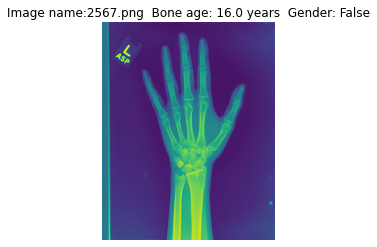

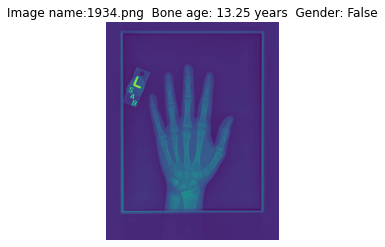

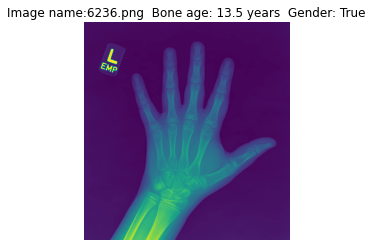

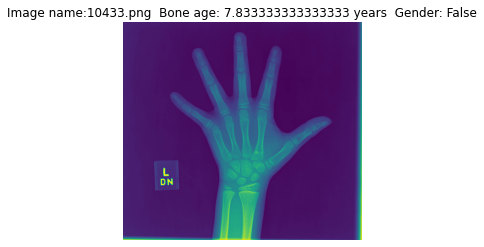

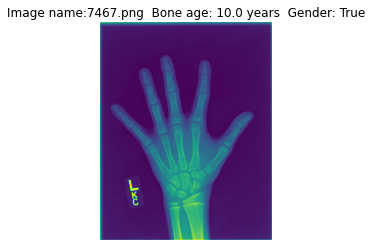

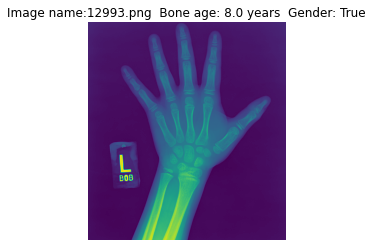

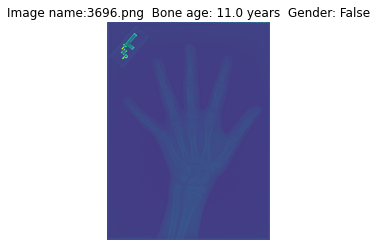

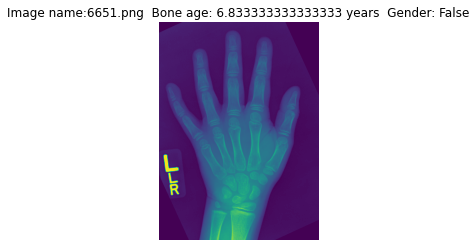

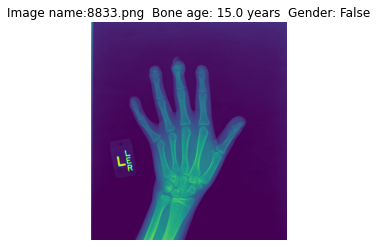

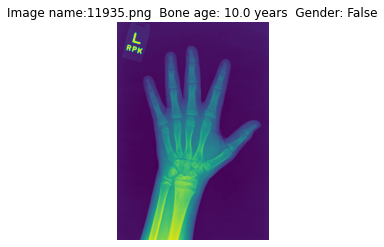

In [22]:
for filename, boneage, gender in train_dataset[['id','boneage','male']].sample(10).values: #เป็นคำสั่งวนลูปเพื่อแสดงภาพ และข้อมูลของภาพที่เก็บไว้ใน Train_df (ชื่อ อายุ เพศ)
    train_img = mpimg.imread(os.path.join(path,'boneage_training_dataset/')+ filename) # เป็นคำสั่งที่ใช้ในการนำรูปเข้ามา
    plt.title('Image name:{}  Bone age: {} years  Gender: {}'.format(filename, boneage/12, gender)) # แสดงหัวเรื่องโดยบอกถึง ชื่อ อายุ(ปี) และเพศ ของแต่ละภาพ
    plt.imshow(train_img) # แสดงรูปภาพ
    plt.axis('off')
    plt.show()

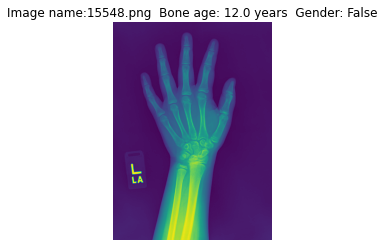

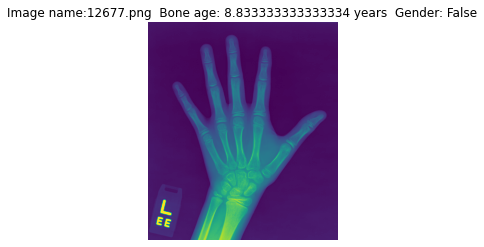

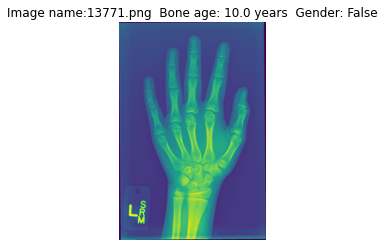

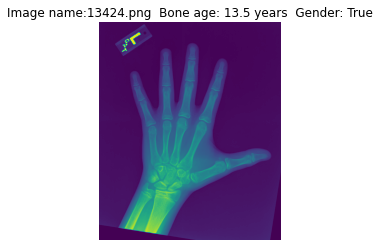

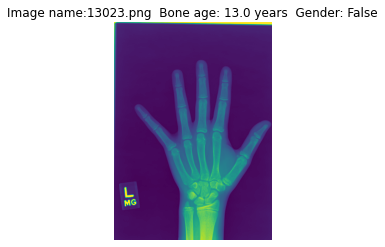

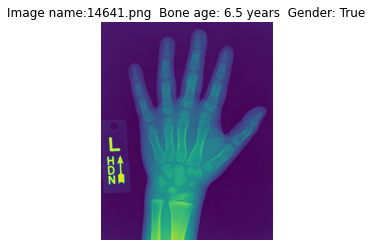

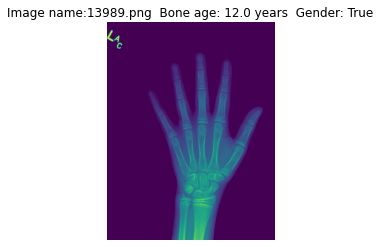

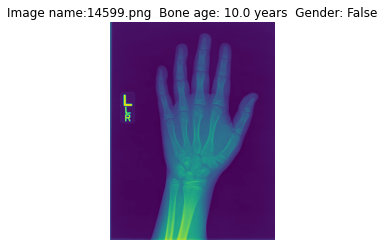

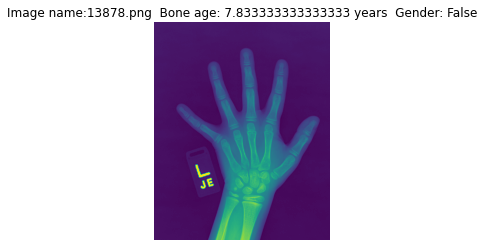

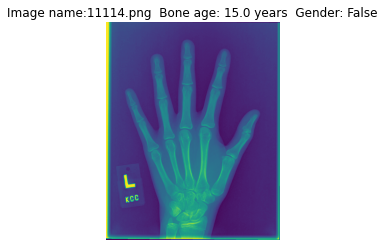

In [23]:
for filename, boneage, gender in validation_dataset[['id','boneage','male']].sample(10).values: #เป็นคำสั่งวนลูปเพื่อแสดงภาพ และข้อมูลของภาพที่เก็บไว้ใน Train_df (ชื่อ อายุ เพศ)
    validation_img = mpimg.imread(os.path.join(path,'boneage_validation_dataset/')+ filename) # เป็นคำสั่งที่ใช้ในการนำรูปเข้ามา
    plt.title('Image name:{}  Bone age: {} years  Gender: {}'.format(filename, boneage/12, gender)) # แสดงหัวเรื่องโดยบอกถึง ชื่อ อายุ(ปี) และเพศ ของแต่ละภาพ
    plt.imshow(validation_img) # แสดงรูปภาพ
    plt.axis('off')
    plt.show()

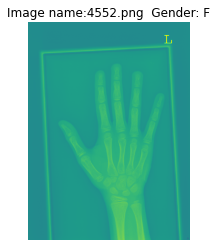

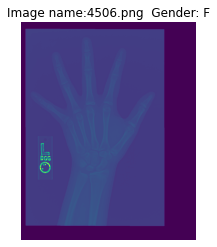

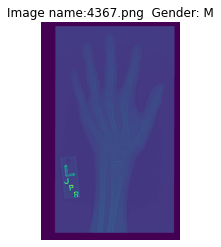

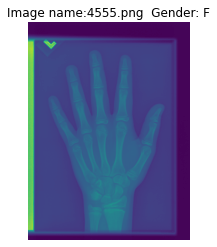

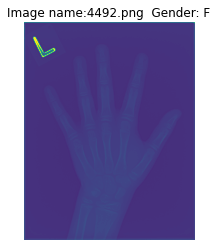

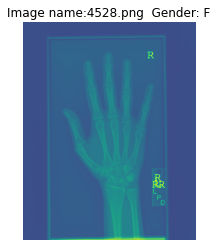

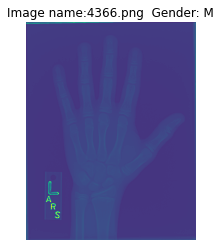

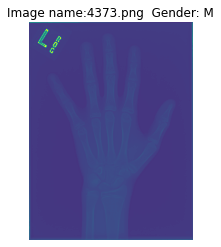

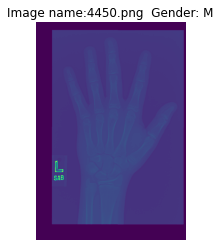

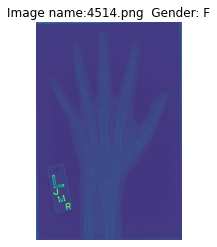

In [24]:
for filename, gender in test_dataset[['Case ID','Sex']].sample(10).values: #เป็นคำสั่งวนลูปเพื่อแสดงภาพ และข้อมูลของภาพที่เก็บไว้ใน Train_df (ชื่อ เพศ)
    test_img = mpimg.imread(os.path.join(path,'boneage-test-dataset/')+ filename) # เป็นคำสั่งที่ใช้ในการนำรูปเข้ามา
    plt.title('Image name:{}  Gender: {}'.format(filename, gender)) # แสดงหัวเรื่องโดยบอกถึง ชื่อ อายุ(ปี) และเพศ ของแต่ละภาพ
    plt.imshow(test_img) # แสดงรูปภาพ
    plt.axis('off')
    plt.show()

In [25]:
#library required for image preprocessing 
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from  keras.applications.inception_v3 import preprocess_input 

In [26]:
#reducing down the size of the image 
img_size = 500 # ลดขนาดรูปภาพ

In [27]:
train_data_generator = ImageDataGenerator(preprocessing_function = preprocess_input)
val_data_generator = ImageDataGenerator(preprocessing_function = preprocess_input)

In [28]:
#train data generator
train_generator = train_data_generator.flow_from_dataframe(
    dataframe = train_dataset,
    directory = (os.path.join(path,'boneage_training_dataset/')),
    x_col= 'id',
    y_col= 'bone_age_z',
    class_mode= 'raw',
    start_epoch=0,
    num_epochs=60,
    lr=0.0001,
    patience=2,
    batch_size=20,
    num_workers=0,
    num_gpus=1,
    gpus=0,
    target_size = (img_size, img_size))

Found 10089 validated image filenames.


In [29]:
#validation data generator
val_generator = val_data_generator.flow_from_dataframe(
    dataframe = validation_dataset,
    directory = (os.path.join(path,'boneage_validation_dataset/')),
    x_col = 'id',
    y_col = 'bone_age_z',
    class_mode = 'raw',
    start_epoch=0,
    num_epochs=60,
    lr=0.0001,
    patience=2,
    batch_size=20,
    num_workers=0,
    num_gpus=1,
    gpus=0,
    target_size = (img_size, img_size))

Found 2522 validated image filenames.


In [30]:
#test data generator
test_data_generator = ImageDataGenerator(preprocessing_function = preprocess_input)
test_generator = test_data_generator.flow_from_directory(
    directory = (os.path.join(path,'boneage-test-dataset/')),
    target_size = (img_size,img_size),
    class_mode = 'binary',classes=['.'])

Found 200 images belonging to 1 classes.


# Model

In [31]:
from tensorflow.keras.layers import GlobalMaxPooling2D, Dense,Flatten
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint,EarlyStopping,ReduceLROnPlateau
from tensorflow.keras import Sequential
import datetime

In [32]:
model_1 = tf.keras.applications.inception_v3.InceptionV3(input_shape = (img_size, img_size, 3),
                                            include_top=False,
                                            weights='imagenet',
                                            input_tensor=None,
                                            pooling=None,
                                            classes=1,
                                            classifier_activation='softmax')
model_1.trainable = True
model_2 = Sequential()
model_2.add(model_1)
model_2.add(GlobalMaxPooling2D())
model_2.add(Flatten())
model_2.add(Dense(1))
model_2.add(Dense(100384,activation = 'relu'))
model_2.add(Dense(1000,activation = 'linear'))

#compile model
model_2.compile(loss ='mse', optimizer= 'adam', metrics = [tf.keras.metrics.MeanAbsoluteError(name='mae')] )

#model summary
model_2.summary()

87910968/87910968 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 14, 14, 2048)      21802784  
                                                                 
 global_max_pooling2d (Globa  (None, 2048)             0         
 lMaxPooling2D)                                                  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 1)                 2049      
                                                                 
 dense_1 (Dense)             (None, 100384)            200768    
                                                                 
 dense_2 (Dense)             (None, 1000)              10

# Training

In [33]:
# Load the TensorBoard notebook extension # Tensorflow รองรับกับเครื่องที่
%load_ext tensorboard
logs_dir = '.\logs'

In [34]:
#early stopping
early_stopping = EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience= 5,
                              verbose=0, mode='auto')

In [35]:
#model checkpoint
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True)
mc

In [36]:
#tensorboard callback
logdir = os.path.join(logs_dir,datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))
tensorboard_callback =  TensorBoard(logdir, histogram_freq = 1)
tensorboard_callback

In [37]:
#reduce lr on plateau
red_lr_plat = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)
red_lr_plat

In [38]:
callbacks = [tensorboard_callback,early_stopping,mc,red_lr_plat]
callbacks

In [39]:
def plot_it(history):
    '''function to plot training and validation error'''
    fig, ax = plt.subplots( figsize=(20,10))
    ax.plot(history.history['mae'])
    ax.plot(history.history['mae'])
    plt.title('Model Error')
    plt.ylabel('error')
    plt.xlabel('epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')
    ax.grid(color='black')
    plt.show()

In [ ]:
#fit model
history = model_2.fit(train_generator,
                            steps_per_epoch = 315, # step_per_epoch = train_dataset/bach_size = 10089/32
                            validation_data = val_generator,
                            validation_steps = 1,
                            epochs = 60,
                            callbacks= callbacks)
history
%tensorboard --logdir logs
plot_it(history)

Epoch 1/60
182/315 [================>.............] - ETA: 14:58 - loss: 0.9478 - mae: 0.7694